In [1]:
import sys; sys.path.insert(0, '../../')
from definitions import *
import numpy as np
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMRegressor
import torch
from src.data.dataset import TimeSeriesDataset
from src.data import dicts
from src.data.functions import torch_ffill
from src.features.derived_features import shock_index, partial_sofa, bun_cr
from src.features.rolling import RollingStatistic
from src.features.signatures.compute import RollingSignature
from src.model.model_selection import stratified_kfold_cv
from src.model.optimizer import CVThresholdOptimizer

# Load the dataset
dataset = TimeSeriesDataset().load(DATA_DIR + '/raw/data.tsd')

# Load the training labels
labels = load_pickle(DATA_DIR + '/processed/labels/utility_scores.pickle')

# First get counts of the laboratory values
count_variables = dicts.feature_types['laboratory'] + ['Temp']
counts = RollingStatistic(statistic='count', window_length=8).transform(dataset[count_variables])
dataset.add_features(counts)

# Apply a forward fill
dataset.data = torch_ffill(dataset.data)

# Add on some additional features
dataset['ShockIndex'] = shock_index(dataset)
dataset['PartialSOFA'] = partial_sofa(dataset)
dataset['BUN/CR'] = bun_cr(dataset)

# Now moments
changing_vars = dicts.feature_types['vitals']
dataset.add_features(RollingStatistic(statistic='moments', window_length=7).transform(dataset[changing_vars]))

# # Now generate some rolling window features
max_vals = RollingStatistic(statistic='max', window_length=6).transform(dataset[dicts.feature_types['vitals']])
min_vals = RollingStatistic(statistic='min', window_length=6).transform(dataset[dicts.feature_types['vitals']])
dataset.add_features(torch.cat((max_vals, min_vals), 2))

# Now some rolling signatures
roller = RollingSignature(window=7, depth=3, aug_list=['leadlag'], logsig=True)
for vbl in ['BUN/CR', 'PartialSOFA', 'MAP', 'HR', 'SBP']:
    signatures = roller.transform(dataset[vbl])
    dataset.add_features(signatures)

# Extract machine learning data
X = dataset.to_ml()
assert len(X) == len(labels)    # Sanity check

# Setup cv
cv, cv_id = stratified_kfold_cv(dataset, labels, n_splits=5, seed=5)
#cv = load_pickle(MODELS_DIR + '/cross_validation/cv_folds.pkl')
print("cv: ", cv)
print("cv_id: ", cv_id)

# Load in the lgbm gridsearch
#lgbm_params = load_pickle(MODELS_DIR + '/official/lgb_fast_params.pkl')

# Regressor
print('Training model...')
#clf = LGBMRegressor().set_params(**lgbm_params)
clf = LGBMRegressor()
predictions = cross_val_predict(clf, X, labels, cv=cv, n_jobs=-1)

# Evaluation
print('Thresholding...')
scores = CVThresholdOptimizer(labels, predictions).optimize(cv, parallel=True)

print('Average: {:.3f}'.format(np.mean(scores)))

<function RollingStatistic.transform at 0x000001A0835800D0> 
  1032.32 ms
<function RollingStatistic.transform at 0x000001A0835800D0> 
  2602.70 ms
<function RollingStatistic.transform at 0x000001A0835800D0> 
  356.37 ms
<function RollingStatistic.transform at 0x000001A0835800D0> 
  362.25 ms
<function RollingSignature.transform at 0x000001A0835B4488> 
  874.43 ms
<function RollingSignature.transform at 0x000001A0835B4488> 
  936.69 ms
<function RollingSignature.transform at 0x000001A0835B4488> 
  1080.09 ms
<function RollingSignature.transform at 0x000001A0835B4488> 
  829.22 ms
<function RollingSignature.transform at 0x000001A0835B4488> 
  888.20 ms
cv:  [[array([     0,      1,      2, ..., 242158, 242159, 242160], dtype=int64), array([   548,    549,    550, ..., 241934, 241935, 241936], dtype=int64)], [array([     0,      1,      2, ..., 242158, 242159, 242160], dtype=int64), array([   164,    165,    166, ..., 242133, 242134, 242135], dtype=int64)], [array([     0,      1,      2

In [21]:
from sklearn.metrics import r2_score

predictions = torch.from_numpy(predictions)
y_diff = np.clip(100 * ( (predictions - labels) / labels), -50, 50)

R2 = r2_score(labels, predictions)

print("CV R2-Score: " + str(R2))

CV R2-Score: -0.10996156534060608


In [22]:
print("Training...")
clf.fit(X,labels)

Training...


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
predictions = cross_val_predict(clf, X, labels, cv=cv, n_jobs=-1)

# Evaluation
print('Thresholding...')
scores = CVThresholdOptimizer(labels, predictions).optimize(cv, parallel=True)

print('Average: {:.3f}'.format(np.mean(scores)))

Thresholding...
Average: 0.284


In [24]:
labels, predictions

(tensor([-0.0500, -0.0500, -0.0500,  ..., -0.0500, -0.0500, -0.0500]),
 array([-0.03708221, -0.03708221, -0.03708221, ..., -0.04973639,
        -0.04874463, -0.04874463]))

In [25]:
from sklearn.metrics import r2_score,mean_squared_error

predictions = torch.from_numpy(predictions)
y_diff = np.clip(100 * ( (predictions - labels) / labels), -50, 50)

R2 = r2_score(labels, predictions)

print("CV R2-Score: " + str(R2))



CV R2-Score: -0.10996156534060608


In [26]:
MSE = mean_squared_error (labels, predictions)
print("MSE: " + str(MSE))
print('Train loss: {:.3f}'.format(MSE))

MSE: 0.049164422889948614
Train loss: 0.049


In [27]:
from src.model.optimizer import optimize_utility_threshold, compute_utility_from_indexes
#predictions = torch.from_numpy(predictions)
tfm_np = lambda x: x.cpu().numpy()
predictions = tfm_np(predictions)
thresh = optimize_utility_threshold(predictions)
train_utility = compute_utility_from_indexes(predictions, thresh)
print('Train utility score: {:.3f}'.format(train_utility))

Train utility score: 0.295


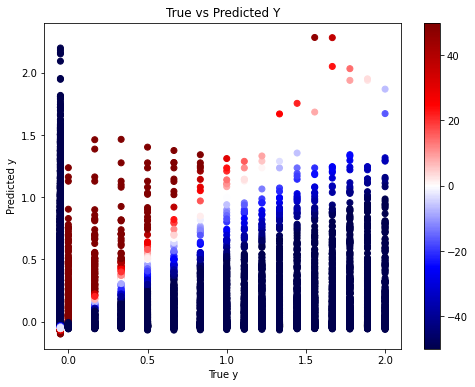

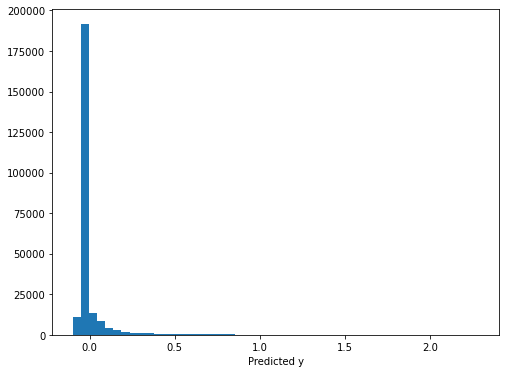

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('True vs Predicted Y')
plt.scatter(labels, predictions, c=y_diff, cmap=plt.cm.seismic)
plt.colorbar()
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.show()

plt.figure(figsize=(8,6))
plt.hist(predictions, 50)
plt.xlabel('Predicted y')
plt.show()

In [29]:
! pip install bayesian-optimization

In [30]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [31]:
X, labels

(tensor([[   84.0000,    97.5000,    37.2800,  ...,        nan,        nan,
                 nan],
         [   80.0000,    99.0000,    37.2800,  ...,        nan,        nan,
                 nan],
         [   74.0000,    97.0000,    37.2200,  ...,        nan,        nan,
                 nan],
         ...,
         [   52.0000,    98.0000,    37.3000,  ...,   499.1250,  6030.4897,
          -7287.7603],
         [   64.0000,    97.0000,    37.3000,  ...,   614.6250,  3858.0508,
          -6814.8242],
         [   64.0000,    99.0000,    37.3000,  ...,   631.5000, -1220.0840,
          -1679.0840]]),
 tensor([-0.0500, -0.0500, -0.0500,  ..., -0.0500, -0.0500, -0.0500]))

In [ ]:
def bayesion_opt_lgbm(X=X, y=labels, init_iter=3, n_iters=7, random_state=11, seed = 101, num_iterations = 200):
  dtrain = lgb.Dataset(data=X, label=y)
  def lgb_r2_score(preds, dtrain):
      labels = dtrain.get_label()
      return 'r2', r2_score(labels, preds), True
  # Objective Function
  def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
        
          params = {'application':'regression','num_iterations': num_iterations,
                    'learning_rate':0.01, 'early_stopping_round':50,
                    'metric':'lgb_r2_score'} # Default parameters
          params["num_leaves"] = int(round(num_leaves))
          params['feature_fraction'] = max(min(feature_fraction, 1), 0)
          params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
          params['max_depth'] = int(round(max_depth))
          params['min_split_gain'] = min_split_gain
          params['min_child_weight'] = min_child_weight
          cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,categorical_feature=[], stratified=False,
                              verbose_eval =None, feval=lgb_r2_score)
          # print(cv_results)
          return np.max(cv_results['r2-mean'])
  # Domain space-- Range of hyperparameters 
  pds = {'num_leaves': (50, 70),
            'feature_fraction': (0.1, 0.9),
            'bagging_fraction': (0.8, 1),
            'max_depth': (13, 23),
            'min_split_gain': (0.001, 0.1),
            'min_child_weight': (10, 25)
            }

  # Surrogate model
  optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
                                    
  # Optimize
  optimizer.maximize(init_points=init_iter, n_iter=n_iters)

optimizer = bayesion_opt_lgbm(X=X.numpy(), y=labels.numpy(), init_iter=5, n_iters=15, random_state=717, seed = 1011, num_iterations = 300)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19409
[LightGBM] [Info] Number of data points in the train set: 193728, number of used features: 125
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19409
[LightGBM] [Info] Number of data points in the train set: 193728, number of used features: 125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing w

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19409
[LightGBM] [Info] Number of data points in the train set: 193728, number of used features: 125
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19409
[LightGBM] [Info] Number of data points in the train set: 193728, number of used features: 125
[LightGBM] [Info] Start training from score -0.019141
[LightGBM] [Info] Start training from score -0.019241
[LightGBM] [Info] Start training from score -0.018791
[LightGBM] [Info] Start training from score -0.018965
[LightGBM] [Info] Start training from score -0.018944
[LightGBM] [

In [ ]:
optimizer.max['params']